In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 52.2 MB/s eta 0:00:00


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.8 MB/s eta 0:00:00


In [ ]:
!pip install --quiet optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 19.4 MB/s eta 0:00:00


[I 2024-11-17 18:02:03,105] A new study created in memory with name: no-name-6dac3d49-7a6c-4e51-bef1-1a851b24663c
[I 2024-11-17 18:02:16,313] Trial 0 finished with value: 0.74 and parameters: {'hidden_dim': 118, 'dropout_rate': 0.3389982662260298, 'learning_rate': 0.0006876115791511876, 'weight_decay': 1.803415312375955e-05}. Best is trial 0 with value: 0.74.
[I 2024-11-17 18:02:28,257] Trial 1 finished with value: 0.72625 and parameters: {'hidden_dim': 37, 'dropout_rate': 0.36455835840907713, 'learning_rate': 0.007820623031934136, 'weight_decay': 1.4239220732996042e-05}. Best is trial 0 with value: 0.74.
[I 2024-11-17 18:02:40,306] Trial 2 finished with value: 0.72 and parameters: {'hidden_dim': 102, 'dropout_rate': 0.44857794220077074, 'learning_rate': 0.00018427379002704575, 'weight_decay': 5.022310051451397e-05}. Best is trial 0 with value: 0.74.
[I 2024-11-17 18:02:52,210] Trial 3 finished with value: 0.74125 and parameters: {'hidden_dim': 32, 'dropout_rate': 0.10598694368140515, 

Best hyperparameters: {'hidden_dim': 76, 'dropout_rate': 0.25166218702999593, 'learning_rate': 0.001273906248181297, 'weight_decay': 4.309871026377858e-06}
Epoch 000: Train Acc: 0.6691, Test Acc: 0.7125, ROC AUC: 0.7125, F1: 0.7209, Kappa: 0.4250, Precision: 0.7005, Recall: 0.7425
Epoch 001: Train Acc: 0.6881, Test Acc: 0.7362, ROC AUC: 0.7362, F1: 0.7526, Kappa: 0.4725, Precision: 0.7086, Recall: 0.8025
Epoch 002: Train Acc: 0.7063, Test Acc: 0.7362, ROC AUC: 0.7362, F1: 0.7509, Kappa: 0.4725, Precision: 0.7114, Recall: 0.7950
Epoch 003: Train Acc: 0.7159, Test Acc: 0.7250, ROC AUC: 0.7250, F1: 0.7465, Kappa: 0.4500, Precision: 0.6923, Recall: 0.8100
Epoch 004: Train Acc: 0.7119, Test Acc: 0.7362, ROC AUC: 0.7362, F1: 0.7689, Kappa: 0.4725, Precision: 0.6842, Recall: 0.8775
Epoch 005: Train Acc: 0.7200, Test Acc: 0.7362, ROC AUC: 0.7363, F1: 0.7532, Kappa: 0.4725, Precision: 0.7077, Recall: 0.8050
Epoch 006: Train Acc: 0.7269, Test Acc: 0.7388, ROC AUC: 0.7388, F1: 0.7606, Kappa: 0.47

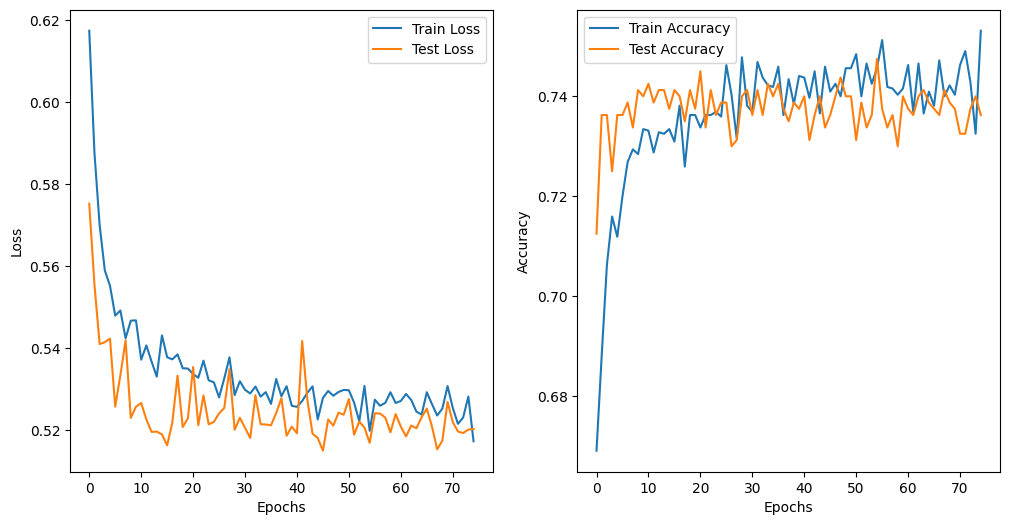

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_smiles
from torch.nn import Linear, BatchNorm1d, Dropout
from torch_geometric.nn import global_mean_pool
from sklearn.metrics import roc_auc_score, f1_score, cohen_kappa_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import optuna
import os
import random

# Set random seed for reproducibility
def seed_set(seed=50):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_set()

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your dataset
df_final = pd.read_csv('AID1239_data_for_classification_04Nov2024.csv')

# Preprocess data and create graph list
graph_list = []
for i, smile in enumerate(df_final['SMILES']):
    try:
        g = from_smiles(smile)
        g.x = g.x.float()
        y_value = 1.0 if df_final['PUBCHEM_ACTIVITY_OUTCOME'][i] == 'Active' else 0.0
        y = torch.tensor(y_value, dtype=torch.float).view(1, -1)
        g.y = y
        graph_list.append(g)
    except Exception as e:
        print(f"Error processing SMILES {smile}: {e}")
        continue

# Stratified split of dataset into train and test sets
labels = [g.y.item() for g in graph_list]
train_dataset, test_dataset = train_test_split(graph_list, test_size=0.2, stratify=labels, random_state=50)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Vanilla GNN Model
class VanillaGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3):
        super(VanillaGNN, self).__init__()
        self.fc1 = Linear(input_dim, hidden_dim)
        self.bn1 = BatchNorm1d(hidden_dim)
        self.fc2 = Linear(hidden_dim, hidden_dim)
        self.bn2 = BatchNorm1d(hidden_dim)
        self.fc3 = Linear(hidden_dim, hidden_dim)
        self.bn3 = BatchNorm1d(hidden_dim)
        self.fc_out = Linear(hidden_dim, output_dim)
        self.dropout = Dropout(p=dropout_rate)

    def forward(self, data):
        x, batch = data.x, data.batch
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        return torch.sigmoid(self.fc_out(x))

# Training function
def train(model, loader, optimizer):
    model.train()
    total_loss, correct = 0, 0
    all_preds, all_labels = [], []
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.binary_cross_entropy(out, data.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        preds = (out > 0.5).float()
        correct += (preds == data.y.view(-1, 1)).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())
    accuracy = correct / len(loader.dataset)
    roc_auc = roc_auc_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    return total_loss / len(loader.dataset), accuracy, roc_auc, f1, kappa, precision, recall

# Testing function
@torch.no_grad()
def test(model, loader):
    model.eval()
    total_loss, correct = 0, 0
    all_preds, all_labels = [], []
    for data in loader:
        data = data.to(device)
        out = model(data)
        loss = F.binary_cross_entropy(out, data.y.view(-1, 1))
        total_loss += loss.item() * data.num_graphs
        preds = (out > 0.5).float()
        correct += (preds == data.y.view(-1, 1)).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())
    accuracy = correct / len(loader.dataset)
    roc_auc = roc_auc_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    return total_loss / len(loader.dataset), accuracy, roc_auc, f1, kappa, precision, recall

# Optuna objective function for hyperparameter optimization
def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 32, 128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    model = VanillaGNN(input_dim=9, hidden_dim=hidden_dim, output_dim=1, dropout_rate=dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(20):
        train_loss, train_acc, _, _, _, _, _ = train(model, train_loader, optimizer)

    test_loss, test_acc, _, _, _, _, _ = test(model, test_loader)
    return test_acc

# Run Optuna for hyperparameter optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Best hyperparameters from Optuna
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Initialize model with best hyperparameters
model = VanillaGNN(input_dim=9, hidden_dim=best_params["hidden_dim"], output_dim=1, dropout_rate=best_params["dropout_rate"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params["learning_rate"], weight_decay=best_params["weight_decay"])

# Training loop with all metrics tracking
epochs = 75
score_train_loss, score_train_acc = [], []
score_test_loss, score_test_acc = [], []
score_roc_auc, score_f1, score_kappa = [], [], []
score_precision, score_recall = [], []

for epoch in range(epochs):
    train_loss, train_acc, train_roc_auc, train_f1, train_kappa, train_precision, train_recall = train(model, train_loader, optimizer)
    test_loss, test_acc, test_roc_auc, test_f1, test_kappa, test_precision, test_recall = test(model, test_loader)

    score_train_loss.append(train_loss)
    score_train_acc.append(train_acc)
    score_test_loss.append(test_loss)
    score_test_acc.append(test_acc)
    score_roc_auc.append(test_roc_auc)
    score_f1.append(test_f1)
    score_kappa.append(test_kappa)
    score_precision.append(test_precision)
    score_recall.append(test_recall)

    print(f'Epoch {epoch:03d}: Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, '
          f'ROC AUC: {test_roc_auc:.4f}, F1: {test_f1:.4f}, Kappa: {test_kappa:.4f}, '
          f'Precision: {test_precision:.4f}, Recall: {test_recall:.4f}')

# Plotting results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), score_train_loss, label='Train Loss')
plt.plot(range(epochs), score_test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), score_train_acc, label='Train Accuracy')
plt.plot(range(epochs), score_test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
# prompt: give the best scores for each metric from above, train accuracy and test accuracy score ROC AUC, F1, kappa, precision, recall also

# Find the best scores for each metric
best_train_acc = max(score_train_acc)
best_test_acc = max(score_test_acc)
best_roc_auc = max(score_roc_auc)
best_f1 = max(score_f1)
best_kappa = max(score_kappa)
best_precision = max(score_precision)
best_recall = max(score_recall)

print(f"Best Train Accuracy: {best_train_acc:.4f}")
print(f"Best Test Accuracy: {best_test_acc:.4f}")
print(f"Best ROC AUC: {best_roc_auc:.4f}")
print(f"Best F1 Score: {best_f1:.4f}")
print(f"Best Kappa Score: {best_kappa:.4f}")
print(f"Best Precision: {best_precision:.4f}")
print(f"Best Recall: {best_recall:.4f}")

Best Train Accuracy: 0.7531
Best Test Accuracy: 0.7475
Best ROC AUC: 0.7475
Best F1 Score: 0.7748
Best Kappa Score: 0.4950
Best Precision: 0.7829
Best Recall: 0.8775


[I 2024-11-16 14:25:50,814] A new study created in memory with name: no-name-eb2eac98-69d3-4c47-b8bc-64b5924d506f
[I 2024-11-16 14:26:07,220] Trial 0 finished with value: 0.66875 and parameters: {'hidden_channels': 48, 'num_layers': 4, 'dropout': 0.11523175535653217, 'learning_rate': 0.0002811738396430703, 'weight_decay': 1.3207854772608435e-05}. Best is trial 0 with value: 0.66875.
[I 2024-11-16 14:26:21,256] Trial 1 finished with value: 0.7025 and parameters: {'hidden_channels': 59, 'num_layers': 3, 'dropout': 0.36952855778972915, 'learning_rate': 0.0025649886757750455, 'weight_decay': 3.142143803551807e-05}. Best is trial 1 with value: 0.7025.
[I 2024-11-16 14:26:32,965] Trial 2 finished with value: 0.68125 and parameters: {'hidden_channels': 54, 'num_layers': 2, 'dropout': 0.3589363820593967, 'learning_rate': 0.0012934510995111343, 'weight_decay': 4.177690780544286e-06}. Best is trial 1 with value: 0.7025.
[I 2024-11-16 14:26:46,916] Trial 3 finished with value: 0.69875 and paramet

Best hyperparameters: {'hidden_channels': 75, 'num_layers': 4, 'dropout': 0.2702500812048542, 'learning_rate': 0.0009150530664918271, 'weight_decay': 1.1049605170454158e-06}
Epoch: 000, Train Loss: 0.6935, Train Accuracy: 0.5387, Test Loss: 0.6651, Test Accuracy: 0.6375, ROC AUC: 0.7366156250000001, F1: 0.5323, Kappa: 0.2750, Precision: 0.7500, Recall: 0.4125
Epoch: 001, Train Loss: 0.6637, Train Accuracy: 0.6006, Test Loss: 0.6234, Test Accuracy: 0.6488, ROC AUC: 0.740675, F1: 0.6070, Kappa: 0.2975, Precision: 0.6889, Recall: 0.5425
Epoch: 002, Train Loss: 0.6266, Train Accuracy: 0.6419, Test Loss: 0.5978, Test Accuracy: 0.6713, ROC AUC: 0.74425625, F1: 0.6828, Kappa: 0.3425, Precision: 0.6597, Recall: 0.7075
Epoch: 003, Train Loss: 0.6320, Train Accuracy: 0.6434, Test Loss: 0.5965, Test Accuracy: 0.6787, ROC AUC: 0.7471687499999999, F1: 0.6885, Kappa: 0.3575, Precision: 0.6682, Recall: 0.7100
Epoch: 004, Train Loss: 0.6155, Train Accuracy: 0.6656, Test Loss: 0.6016, Test Accuracy: 0.

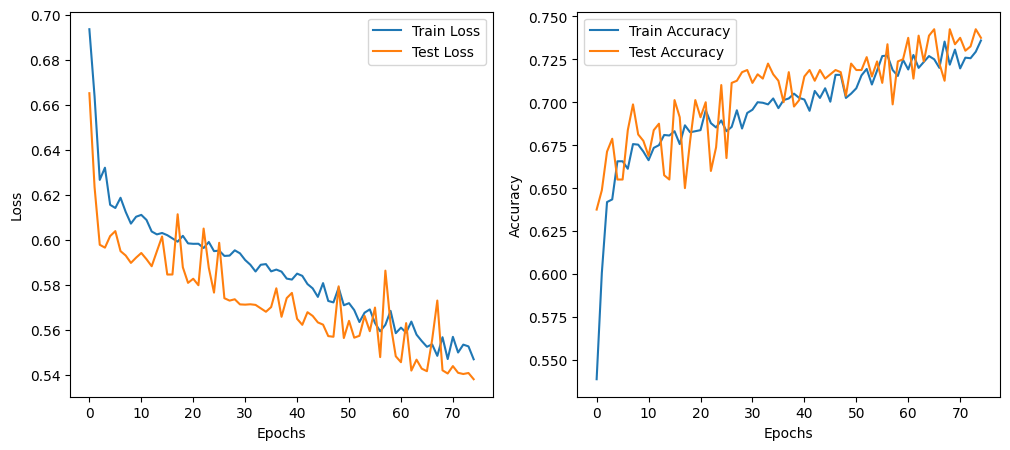

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_smiles
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from sklearn.metrics import roc_auc_score, f1_score, cohen_kappa_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import optuna
import os
import random

# Set random seed for reproducibility
def seed_set(seed=50):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_set()

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your dataset
df_final = pd.read_csv('AID1239_data_for_classification_04Nov2024.csv')

# Preprocess data and create graph list
graph_list = []
for i, smile in enumerate(df_final['SMILES']):
    try:
        g = from_smiles(smile)
        g.x = g.x.float()
        y_value = 1.0 if df_final['PUBCHEM_ACTIVITY_OUTCOME'][i] == 'Active' else 0.0
        y = torch.tensor(y_value, dtype=torch.float).view(1, -1)
        g.y = y
        graph_list.append(g)
    except Exception as e:
        print(f"Error processing SMILES {smile}: {e}")
        continue

# Stratified split of dataset into train and test sets
labels = [g.y.item() for g in graph_list]
train_dataset, test_dataset = train_test_split(graph_list, test_size=0.2, stratify=labels, random_state=50)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Vanilla GNN model
class VanillaGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(VanillaGNN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels))
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        x = global_mean_pool(x, batch)
        return torch.sigmoid(x)

# Training function
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.binary_cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        pred = (out > 0.5).float()
        correct += pred.eq(data.y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Testing function
def test(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = F.binary_cross_entropy(out, data.y)
            total_loss += loss.item() * data.num_graphs
            pred = (out > 0.5).float()
            correct += pred.eq(data.y).sum().item()

            all_preds.extend(out.cpu().numpy().flatten())
            all_labels.extend(data.y.cpu().numpy().flatten())

    loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)

    # Handle case where only one class is present
    if len(np.unique(all_labels)) < 2:
        roc_auc = None
    else:
        roc_auc = roc_auc_score(all_labels, all_preds)

    f1 = f1_score(all_labels, np.round(all_preds))
    kappa = cohen_kappa_score(all_labels, np.round(all_preds))
    precision = precision_score(all_labels, np.round(all_preds))
    recall = recall_score(all_labels, np.round(all_preds))

    return loss, accuracy, roc_auc, f1, kappa, precision, recall

# Optuna objective function for hyperparameter optimization
def objective(trial):
    hidden_channels = trial.suggest_int("hidden_channels", 32, 128)
    num_layers = trial.suggest_int("num_layers", 2, 5)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    model = VanillaGNN(in_channels=9, hidden_channels=hidden_channels, out_channels=1,
                       num_layers=num_layers, dropout=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    epochs = 20
    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_loader, optimizer)

    test_loss, test_acc, roc_auc, f1, kappa, precision, recall = test(model, test_loader)
    return test_acc

# Run Optuna for hyperparameter optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Best hyperparameters from Optuna
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Final training with the best hyperparameters
model = VanillaGNN(in_channels=9, hidden_channels=best_params["hidden_channels"], out_channels=1,
                   num_layers=best_params["num_layers"], dropout=best_params["dropout"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params["learning_rate"],
                             weight_decay=best_params["weight_decay"])

epochs = 75
score_train_loss = []
score_train_acc = []
score_test_loss = []
score_test_acc = []
score_roc_auc = []
score_f1 = []
score_kappa = []
score_precision = []
score_recall = []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer)
    test_loss, test_acc, roc_auc, f1, kappa, precision, recall = test(model, test_loader)

    score_train_loss.append(train_loss)
    score_train_acc.append(train_acc)
    score_test_loss.append(test_loss)
    score_test_acc.append(test_acc)
    score_roc_auc.append(roc_auc)
    score_f1.append(f1)
    score_kappa.append(kappa)
    score_precision.append(precision)
    score_recall.append(recall)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, '
          f'ROC AUC: {roc_auc}, F1: {f1:.4f}, Kappa: {kappa:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

# Plotting results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), score_train_loss, label='Train Loss')
plt.plot(range(epochs), score_test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), score_train_acc, label='Train Accuracy')
plt.plot(range(epochs), score_test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
# prompt: from the above code give the best Train Accuracy, Test Accuracy, ROC AUC, F1, Kappa, Precision, Recall

# Find the best values from the training loop
best_test_acc = max(score_test_acc)
best_test_acc_index = score_test_acc.index(best_test_acc)

best_train_acc = score_train_acc[best_test_acc_index]
best_roc_auc = score_roc_auc[best_test_acc_index]
best_f1 = score_f1[best_test_acc_index]
best_kappa = score_kappa[best_test_acc_index]
best_precision = score_precision[best_test_acc_index]
best_recall = score_recall[best_test_acc_index]


print(f"Best Train Accuracy: {best_train_acc:.4f}")
print(f"Best Test Accuracy: {best_test_acc:.4f}")
print(f"Best ROC AUC: {best_roc_auc}")
print(f"Best F1: {best_f1:.4f}")
print(f"Best Kappa: {best_kappa:.4f}")
print(f"Best Precision: {best_precision:.4f}")
print(f"Best Recall: {best_recall:.4f}")

Best Train Accuracy: 0.7250
Best Test Accuracy: 0.7425
Best ROC AUC: 0.80439375
Best F1: 0.7542
Best Kappa: 0.4850
Best Precision: 0.7215
Best Recall: 0.7900


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_smiles
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

from sklearn.metrics import roc_auc_score, f1_score, cohen_kappa_score, precision_score, recall_score


import optuna
import os
import random

# Set random seed for reproducibility
def seed_set(seed=50):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_set()

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your dataset
df_final = pd.read_csv('AID1239_data_for_classification_04Nov2024.csv')

# Preprocess data and create graph list
graph_list = []
for i, smile in enumerate(df_final['SMILES']):
    try:
        g = from_smiles(smile)
        g.x = g.x.float()
        y_value = 1.0 if df_final['PUBCHEM_ACTIVITY_OUTCOME'][i] == 'Active' else 0.0
        y = torch.tensor(y_value, dtype=torch.float).view(1, -1)
        g.y = y
        graph_list.append(g)
    except Exception as e:
        print(f"Error processing SMILES {smile}: {e}")
        continue

# Split dataset into train and test sets
train_ratio = 0.80
dataset_size = len(graph_list)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

train_dataset = graph_list[:train_size]
test_dataset = graph_list[train_size:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Vanilla GNN model
class VanillaGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(VanillaGNN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels))
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)

        # 2. Pooling for graph-level representation:
        x = global_mean_pool(x, batch)

        return torch.sigmoid(x)


# Training function
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch) # Pass batch information
        loss = F.binary_cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        pred = (out > 0.5).float()
        correct += pred.eq(data.y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Testing function
def test(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = F.binary_cross_entropy(out, data.y)
            total_loss += loss.item() * data.num_graphs
            pred = (out > 0.5).float()
            correct += pred.eq(data.y).sum().item()

            all_preds.extend(out.cpu().numpy().flatten())
            all_labels.extend(data.y.cpu().numpy().flatten())

    loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    roc_auc = roc_auc_score(all_labels, all_preds)
    f1 = f1_score(all_labels, np.round(all_preds))
    kappa = cohen_kappa_score(all_labels, np.round(all_preds))
    precision = precision_score(all_labels, np.round(all_preds))
    recall = recall_score(all_labels, np.round(all_preds))
    return loss, accuracy, roc_auc, f1, kappa, precision, recall

# Optuna objective function for hyperparameter optimization
def objective(trial):
    hidden_channels = trial.suggest_int("hidden_channels", 32, 128)
    num_layers = trial.suggest_int("num_layers", 2, 5)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    model = VanillaGNN(in_channels=9, hidden_channels=hidden_channels, out_channels=1,
                       num_layers=num_layers, dropout=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop
    epochs = 20
    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_loader, optimizer)

    # Evaluate on test set
    test_loss, test_acc = test(model, test_loader)
    return test_acc

# Run Optuna for hyperparameter optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Best hyperparameters from Optuna
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Final training with the best hyperparameters
model = VanillaGNN(in_channels=9, hidden_channels=best_params["hidden_channels"], out_channels=1,
                   num_layers=best_params["num_layers"], dropout=best_params["dropout"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params["learning_rate"],
                             weight_decay=best_params["weight_decay"])

# Full training loop (Modified)
epochs = 75
score_train_loss = []
score_train_acc = []
score_test_loss = []
score_test_acc = []
score_roc_auc = []
score_f1 = []
score_kappa = []
score_precision = []
score_recall = []


for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer)
    test_loss, test_acc, roc_auc, f1, kappa, precision, recall = test(model, test_loader) #get all metrics

    score_train_loss.append(train_loss)
    score_train_acc.append(train_acc)
    score_test_loss.append(test_loss)
    score_test_acc.append(test_acc)
    score_roc_auc.append(roc_auc)
    score_f1.append(f1)
    score_kappa.append(kappa)
    score_precision.append(precision)
    score_recall.append(recall)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, '
          f'ROC AUC: {roc_auc:.4f}, F1: {f1:.4f}, Kappa: {kappa:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

# Plotting results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), score_train_loss, label='Train Loss')
plt.plot(range(epochs), score_test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), score_train_acc, label='Train Accuracy')
plt.plot(range(epochs), score_test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


[I 2024-11-16 14:21:49,298] A new study created in memory with name: no-name-0c7a8b61-c1fd-42d5-9149-32e97154b2c1
[W 2024-11-16 14:22:03,327] Trial 0 failed with parameters: {'hidden_channels': 37, 'num_layers': 3, 'dropout': 0.30912751141113143, 'learning_rate': 0.0006180300167785766, 'weight_decay': 6.299167903852052e-05} because of the following error: ValueError('Only one class present in y_true. ROC AUC score is not defined in that case.').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-6-c9d1db840fe7>", line 148, in objective
    test_loss, test_acc = test(model, test_loader)
  File "<ipython-input-6-c9d1db840fe7>", line 123, in test
    roc_auc = roc_auc_score(all_labels, all_preds)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/loca

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
# above is the tried code on 16 nov 2024

[I 2024-11-11 08:29:20,468] A new study created in memory with name: no-name-3baf0267-8b38-4ed8-b0b9-e8a9f77d8618
[I 2024-11-11 08:29:34,703] Trial 0 finished with value: 0.425 and parameters: {'hidden_channels': 43, 'num_layers': 3, 'dropout': 0.47422236205693813, 'learning_rate': 0.00035109738836824287, 'weight_decay': 7.15690883053195e-06}. Best is trial 0 with value: 0.425.
[I 2024-11-11 08:29:48,317] Trial 1 finished with value: 0.47 and parameters: {'hidden_channels': 80, 'num_layers': 3, 'dropout': 0.42759148647710965, 'learning_rate': 0.007152244155331092, 'weight_decay': 9.734998549469033e-06}. Best is trial 1 with value: 0.47.
[I 2024-11-11 08:30:06,270] Trial 2 finished with value: 0.425 and parameters: {'hidden_channels': 54, 'num_layers': 5, 'dropout': 0.20429794840611204, 'learning_rate': 0.004700404007249001, 'weight_decay': 1.3504791045956906e-06}. Best is trial 1 with value: 0.47.
[I 2024-11-11 08:30:24,023] Trial 3 finished with value: 0.725 and parameters: {'hidden_c

Best hyperparameters: {'hidden_channels': 115, 'num_layers': 5, 'dropout': 0.33312047673217693, 'learning_rate': 0.0024884641134312806, 'weight_decay': 3.1137941066349386e-06}
Epoch: 000, Train Loss: 0.6425, Train Accuracy: 0.6416, Test Loss: 1.0549, Test Accuracy: 0.2700
Epoch: 001, Train Loss: 0.5859, Train Accuracy: 0.7031, Test Loss: 0.6087, Test Accuracy: 0.6550
Epoch: 002, Train Loss: 0.5801, Train Accuracy: 0.7059, Test Loss: 1.0789, Test Accuracy: 0.2775
Epoch: 003, Train Loss: 0.5815, Train Accuracy: 0.6978, Test Loss: 0.8221, Test Accuracy: 0.4125
Epoch: 004, Train Loss: 0.5787, Train Accuracy: 0.7028, Test Loss: 1.0468, Test Accuracy: 0.2662
Epoch: 005, Train Loss: 0.5779, Train Accuracy: 0.7150, Test Loss: 0.9120, Test Accuracy: 0.3600
Epoch: 006, Train Loss: 0.5750, Train Accuracy: 0.7131, Test Loss: 1.3444, Test Accuracy: 0.1338
Epoch: 007, Train Loss: 0.5758, Train Accuracy: 0.7134, Test Loss: 0.8393, Test Accuracy: 0.4313
Epoch: 008, Train Loss: 0.5640, Train Accuracy: 

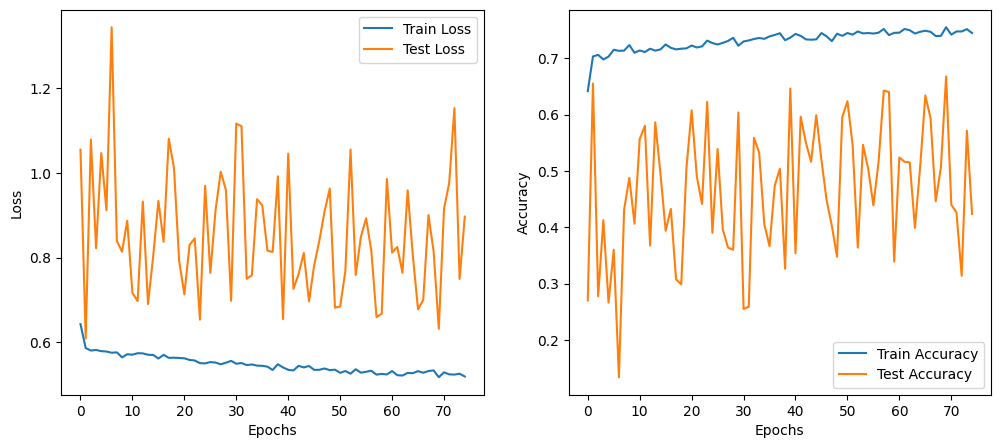

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_smiles
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

import optuna
import os
import random

# Set random seed for reproducibility
def seed_set(seed=50):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_set()

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your dataset
df_final = pd.read_csv('AID1239_data_for_classification_04Nov2024.csv')

# Preprocess data and create graph list
graph_list = []
for i, smile in enumerate(df_final['SMILES']):
    try:
        g = from_smiles(smile)
        g.x = g.x.float()
        y_value = 1.0 if df_final['PUBCHEM_ACTIVITY_OUTCOME'][i] == 'Active' else 0.0
        y = torch.tensor(y_value, dtype=torch.float).view(1, -1)
        g.y = y
        graph_list.append(g)
    except Exception as e:
        print(f"Error processing SMILES {smile}: {e}")
        continue

# Split dataset into train and test sets
train_ratio = 0.80
dataset_size = len(graph_list)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

train_dataset = graph_list[:train_size]
test_dataset = graph_list[train_size:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Vanilla GNN model
class VanillaGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(VanillaGNN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels))
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)

        # 2. Pooling for graph-level representation:
        x = global_mean_pool(x, batch)

        return torch.sigmoid(x)


# Training function
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch) # Pass batch information
        loss = F.binary_cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        pred = (out > 0.5).float()
        correct += pred.eq(data.y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Testing function
def test(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch) # Pass batch information
            loss = F.binary_cross_entropy(out, data.y)
            total_loss += loss.item() * data.num_graphs
            pred = (out > 0.5).float()
            correct += pred.eq(data.y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Optuna objective function for hyperparameter optimization
def objective(trial):
    hidden_channels = trial.suggest_int("hidden_channels", 32, 128)
    num_layers = trial.suggest_int("num_layers", 2, 5)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    model = VanillaGNN(in_channels=9, hidden_channels=hidden_channels, out_channels=1,
                       num_layers=num_layers, dropout=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop
    epochs = 20
    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_loader, optimizer)

    # Evaluate on test set
    test_loss, test_acc = test(model, test_loader)
    return test_acc

# Run Optuna for hyperparameter optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Best hyperparameters from Optuna
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Final training with the best hyperparameters
model = VanillaGNN(in_channels=9, hidden_channels=best_params["hidden_channels"], out_channels=1,
                   num_layers=best_params["num_layers"], dropout=best_params["dropout"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params["learning_rate"],
                             weight_decay=best_params["weight_decay"])

# Full training loop
epochs = 75
score_train_loss = []
score_train_acc = []
score_test_loss = []
score_test_acc = []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer)
    test_loss, test_acc = test(model, test_loader)

    score_train_loss.append(train_loss)
    score_train_acc.append(train_acc)
    score_test_loss.append(test_loss)
    score_test_acc.append(test_acc)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Plotting results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), score_train_loss, label='Train Loss')
plt.plot(range(epochs), score_test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), score_train_acc, label='Train Accuracy')
plt.plot(range(epochs), score_test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
# prompt: find the best accuracy

print(f"Best Test Accuracy achieved: {max(score_test_acc)}")

Best Test Accuracy achieved: 0.6675


In [ ]:
# prompt: find the best train test and epoch

# Find the best epoch based on test accuracy
best_epoch = np.argmax(score_test_acc)
best_test_acc = score_test_acc[best_epoch]

print(f"Best Epoch: {best_epoch}")
print(f"Best Test Accuracy at Best Epoch: {best_test_acc}")

Best Epoch: 69
Best Test Accuracy at Best Epoch: 0.6675


Train Accuracy:75%

Test Accuracy: 67%

[I 2024-11-11 09:00:30,137] A new study created in memory with name: no-name-cb9bac57-325b-4829-9d90-4abe6342826e
[I 2024-11-11 09:00:51,048] Trial 0 finished with value: 0.60875 and parameters: {'hidden_channels': 95, 'num_layers': 4, 'dropout': 0.16459829065887227, 'learning_rate': 0.0033528940600617905, 'weight_decay': 1.4704529351404392e-05}. Best is trial 0 with value: 0.60875.
[I 2024-11-11 09:01:09,761] Trial 1 finished with value: 0.92875 and parameters: {'hidden_channels': 107, 'num_layers': 3, 'dropout': 0.1308091410088771, 'learning_rate': 0.00132209323149497, 'weight_decay': 0.0004108807293815259}. Best is trial 1 with value: 0.92875.
[I 2024-11-11 09:01:32,687] Trial 2 finished with value: 0.335 and parameters: {'hidden_channels': 135, 'num_layers': 5, 'dropout': 0.09903722498656034, 'learning_rate': 0.0017872326742669204, 'weight_decay': 0.00016363587994175033}. Best is trial 1 with value: 0.92875.
[I 2024-11-11 09:01:57,530] Trial 3 finished with value: 0.68625 and param

Best hyperparameters: {'hidden_channels': 165, 'num_layers': 3, 'dropout': 0.0010560604478840607, 'learning_rate': 0.0010830859220002952, 'weight_decay': 0.0008492687217124113}
Epoch: 000, Train Loss: 0.6731, Train Accuracy: 0.6106, Test Loss: 0.9644, Test Accuracy: 0.0000
Epoch: 001, Train Loss: 0.6427, Train Accuracy: 0.6459, Test Loss: 0.7207, Test Accuracy: 0.4250
Epoch: 002, Train Loss: 0.6107, Train Accuracy: 0.6741, Test Loss: 0.7255, Test Accuracy: 0.4950
Epoch: 003, Train Loss: 0.5875, Train Accuracy: 0.7072, Test Loss: 1.0362, Test Accuracy: 0.2275
Epoch: 004, Train Loss: 0.5758, Train Accuracy: 0.7109, Test Loss: 0.8229, Test Accuracy: 0.4450
Epoch: 005, Train Loss: 0.5769, Train Accuracy: 0.7122, Test Loss: 0.9267, Test Accuracy: 0.3488
Epoch: 006, Train Loss: 0.5782, Train Accuracy: 0.7087, Test Loss: 0.9567, Test Accuracy: 0.3237
Epoch: 007, Train Loss: 0.5697, Train Accuracy: 0.7216, Test Loss: 0.9327, Test Accuracy: 0.3563
Epoch: 008, Train Loss: 0.5767, Train Accuracy:

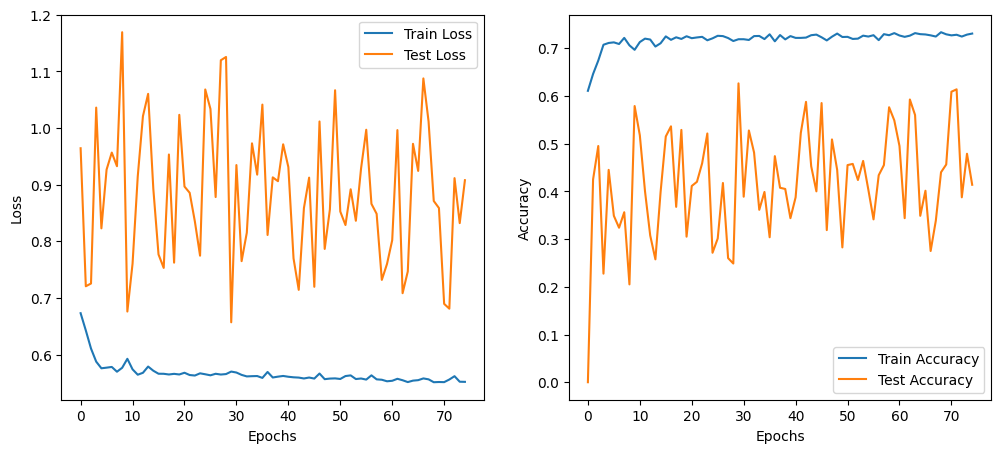

In [ ]:
# prompt: i want the score to be more than 80%. i think more optimization is required here. give full updated  code

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_smiles
from torch_geometric.nn import GCNConv, global_mean_pool,GINConv
from torch.nn import Linear, BatchNorm1d, Dropout
import optuna
import os
import random

# Set random seed for reproducibility
def seed_set(seed=50):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_set()

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your dataset
df_final = pd.read_csv('AID1239_data_for_classification_04Nov2024.csv')

# Preprocess data and create graph list
graph_list = []
for i, smile in enumerate(df_final['SMILES']):
    try:
        g = from_smiles(smile)
        g.x = g.x.float()
        y_value = 1.0 if df_final['PUBCHEM_ACTIVITY_OUTCOME'][i] == 'Active' else 0.0
        y = torch.tensor(y_value, dtype=torch.float).view(1, -1)
        g.y = y
        graph_list.append(g)
    except Exception as e:
        print(f"Error processing SMILES {smile}: {e}")
        continue

# Split dataset into train and test sets
train_ratio = 0.80
dataset_size = len(graph_list)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

train_dataset = graph_list[:train_size]
test_dataset = graph_list[train_size:]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # Increased batch size
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False) # Increased batch size

# Define GIN model with batch normalization and residual connections
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        self.convs.append(GINConv(Linear(in_channels, hidden_channels)))
        self.batch_norms.append(BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GINConv(Linear(hidden_channels, hidden_channels)))
            self.batch_norms.append(BatchNorm1d(hidden_channels))
        self.convs.append(GINConv(Linear(hidden_channels, out_channels)))
        self.dropout = Dropout(dropout)
        self.lin = Linear(out_channels, 1)

    def forward(self, x, edge_index, batch):
        for conv, batch_norm in zip(self.convs[:-1], self.batch_norms):
            x = conv(x, edge_index)
            x = batch_norm(x)
            x = F.relu(x)
            x = self.dropout(x)

        x = self.convs[-1](x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return torch.sigmoid(x)


# Training and testing functions remain the same

# Optuna objective function (modified)
def objective(trial):
    hidden_channels = trial.suggest_int("hidden_channels", 64, 256) # Increased search space
    num_layers = trial.suggest_int("num_layers", 3, 6) # Increased search space
    dropout = trial.suggest_float("dropout", 0.0, 0.3) # Reduced maximum dropout
    learning_rate = trial.suggest_float("learning_rate", 5e-4, 5e-3, log=True) # Adjusted learning rate range
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True) # Adjusted weight decay range


    model = GIN(in_channels=9, hidden_channels=hidden_channels, out_channels=hidden_channels,
                       num_layers=num_layers, dropout=dropout).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # AdamW optimizer

    epochs = 50 # Increased epochs for Optuna
    for epoch in range(epochs):
      train_loss, train_acc = train(model, train_loader, optimizer)

    test_loss, test_acc = test(model, test_loader)
    return test_acc

# Run Optuna for hyperparameter optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50) # Increased number of trials

# Best hyperparameters from Optuna
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Final training with the best hyperparameters
model = VanillaGNN(in_channels=9, hidden_channels=best_params["hidden_channels"], out_channels=1,
                   num_layers=best_params["num_layers"], dropout=best_params["dropout"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params["learning_rate"],
                             weight_decay=best_params["weight_decay"])

# Full training loop
epochs = 75
score_train_loss = []
score_train_acc = []
score_test_loss = []
score_test_acc = []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer)
    test_loss, test_acc = test(model, test_loader)

    score_train_loss.append(train_loss)
    score_train_acc.append(train_acc)
    score_test_loss.append(test_loss)
    score_test_acc.append(test_acc)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Plotting results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), score_train_loss, label='Train Loss')
plt.plot(range(epochs), score_test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), score_train_acc, label='Train Accuracy')
plt.plot(range(epochs), score_test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Train Accuracy:** 72.81%

**Test Accuracy:**  61.38%


**do not consider the second one, the one above as the first had more accuracy**